In [1]:
# import packages 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import os
import re
from scipy import stats
from scipy import signal

In [2]:
# Save progress 
HISTORY_FILEPATH = r"C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02.py"
def SAVE_PROGRESS(dst_file_path):
    from datetime import datetime
    dst_dir_path, dst_file_name = os.path.split(dst_file_path)
    dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
    dst_file_path = os.path.join(dst_dir_path, dst_file_name)
    if not os.path.isdir(dst_dir_path):
        os.makedirs(dst_dir_path)
    if os.path.exists(dst_file_path):
        os.remove(dst_file_path)
    %history -t -g -f $dst_file_path
    print("Progress saved to: " + dst_file_path)

In [3]:
#FUNCTION: list packages 
def listPkgNames(srcDir):
    import os
    assert(os.path.exists(srcDir))
    pkgNameSuffix = "_Pkg"
    subDirNameList = [iSubDirName for iSubDirName in os.listdir(srcDir) if os.path.isdir(srcDir + "\\" + iSubDirName)]
    pkgNameList = [iSubDirName for iSubDirName in subDirNameList if iSubDirName[-len(pkgNameSuffix):] == pkgNameSuffix]
    return pkgNameList

def sortPkgNames(src_pkgNameList):
    PkgNumStrPrefix = r"_F"
    pkgNumStrSuffix = "_Pkg"
    pkgNumRe = PkgNumStrPrefix + r"[0-9]+" + pkgNumStrSuffix
    src_pkgNames = np.array(src_pkgNameList)
    pkgNums = np.zeros(src_pkgNames.shape)
    for iPkg in range(len(src_pkgNames)):
        pkgName = src_pkgNames[iPkg]
        pkgNum = int(re.findall(pkgNumRe, pkgName)[0][len(PkgNumStrPrefix):-len(pkgNumStrSuffix)])
        pkgNums[iPkg] = pkgNum
    return src_pkgNames[np.argsort(pkgNums)]

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [4]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    # spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    # spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            # spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s           
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(float) / duration_s

    return spike_rate

# # This function will shift the filterd waveform 
# def bw_lp_filtering(order, cutoff, fs, src_traces):
#     sos = signal.butter(order, cutoff, "lp", fs = fs, output = "sos")
#     dst_traces = signal.sosfilt(sos, src_traces, axis = -1)
#     return dst_traces

def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces

SAVE_PROGRESS(HISTORY_FILEPATH)   

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [5]:
# stats test function
def stim_step_t_test(spike_rate, test_steps = [1,0]):
    alternative = "greater"
    
    nof_orints = spike_rate.shape[0]
    test_results = []
    pvalues = np.zeros((nof_orints,))
    for i_orient in range(nof_orints):
        a = spike_rate[i_orient, test_steps[0], :]
        b = spike_rate[i_orient, test_steps[1], :] 
        result = stats.ttest_ind(a, b, alternative = alternative)
        test_results.append(result)
        pvalues[i_orient] = result.pvalue
    return pvalues, test_results

def stim_step_diff_t_test(spike_rate, test_steps = [1,0]):
    alternative = "greater"
    
    nof_orints = spike_rate.shape[0]
    test_results = []
    pvalues = np.zeros((nof_orints,))
    for i_orient in range(nof_orints):
        a = spike_rate[i_orient, test_steps[0], :]
        b = spike_rate[i_orient, test_steps[1], :] 
        result = stats.ttest_1samp(a - b, popmean = 0, alternative = alternative)
        test_results.append(result)
        pvalues[i_orient] = result.pvalue
    return pvalues, test_results

def stim_step_sum_t_test(spike_cnt, test_steps = [1,0]):
    alternative = "greater"
    a = np.sum(spike_cnt[:, test_steps[0], :], axis = 0)
    b = np.sum(spike_cnt[:, test_steps[1], :], axis = 0)
    result = stats.ttest_ind(a, b, alternative = alternative)
    return result

def stim_step_gather_mean_t_test(spike_cnt, test_steps = [1,0]):
    alternative = "greater"
    a = np.mean(spike_cnt[:, test_steps[0], :], axis = 0)
    b = np.mean(spike_cnt[:, test_steps[1], :], axis = 0)
    result = stats.ttest_ind(a, b, alternative = alternative)
    return result
    
def stim_step_anova_oneway(spike_rate, test_step = 1):
    nof_orints = spike_rate.shape[0]
    comp_group = []
    for i_orint in range(nof_orints):
        comp_group.append(spike_rate[i_orint, test_step, :])
    result = stats.f_oneway(*comp_group)
    return result

def stim_blank_diff_anova_oneway(spike_rate, test_step = [1,0]):
    nof_orints = spike_rate.shape[0]
    comp_group = []
    for i_orint in range(nof_orints):
        comp_group.append(spike_rate[i_orint, test_step[0], :] - spike_rate[i_orint, test_step[1], :])
    result = stats.f_oneway(*comp_group)
    return result

def calculate_gOSI(responses, orientations):
    gOSI = np.abs(np.sum( responses * np.exp(2.0j * orientations) )) / np.sum(responses)
    return gOSI

def calculate_vec_sum_complex(responses, orientations):
    vec_sum_complex = np.sum(responses * np.exp(1.0j * orientations))
    return vec_sum_complex

def holm_bonferrioni_comparison(pvals, alpha):
    pvals = np.sort(pvals)
    m = len(pvals)
    correct_coeffs = 1/(np.arange(1, m+1)[::-1])
#     print(pvals)
#     print(correct_coeffs)
    effective_alphas = alpha * correct_coeffs
    return np.sum(pvals <= effective_alphas) > 0 
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [6]:
# basic plot functions
def raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)

def stim_time_stamp_axvline(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvline(tstamp_start, color = facecolor_strs[i_step])
            plt.axvline(tstamp_end, color = facecolor_strs[i_step])
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [7]:
# analysis code
def stats_analysis(
    i_roi,
    spike_event,
    dFF,
    bw_order,
    bw_cutoff,
    fs,
    stim_tstamp,
    stim_tstamp_s,
    orient_angles_rad,
    t_test_alpha,
    anova_test_alpha,
    dst_dir_path,
    process_mode = "show",
):
    
    cur_dFF = dFF
    cur_subthreshold_dFF = bw_lp_filtering(order = bw_order,
                                           cutoff = bw_cutoff, 
                                           fs = fs, 
                                           src_traces = cur_dFF,
    )
    cur_spike_event = spike_event.copy()
    # cur_stats_valid_spike_event =cur_spike_event.copy()
    
    # cur_stats_valid_spike_event = cur_spike_event.copy()
    # cur_dFF_valid_mask = cur_dFF > (cur_subthreshold_dFF + 3 * np.std(cur_dFF[cur_spike_event == 0], axis = -1).reshape((-1,1)))
    # cur_stats_valid_spike_event[~ cur_dFF_valid_mask] = 0
    
    cur_spike_cnts = cnt_spike_in_time_stamp(cur_spike_event, stim_tstamp)
    
    # cur_spike_cnts = cnt_spike_in_time_stamp(cur_stats_valid_spike_event, stim_tstamp)

    
    cur_spike_rate = calculate_spike_rate_s(cur_spike_cnts, stim_tstamp_s)
    
    t_test_pvals, t_test_results = stim_step_t_test(cur_spike_rate, test_steps = [1,0])
    diff_t_test_pvals, diff_t_test_results = stim_step_diff_t_test(cur_spike_rate, test_steps = [1,0])
    # gather_t_test_result = stim_step_sum_t_test(cur_spike_cnts, test_steps = [1,0])
    gather_t_test_result = stim_step_gather_mean_t_test(cur_spike_rate, test_steps = [1,0])
    anova_test_result = stim_step_anova_oneway(cur_spike_rate, test_step = 1)
    diff_anova_test_result = stim_blank_diff_anova_oneway(cur_spike_rate, test_step = [1,0])
    
    
    nof_traces = cur_spike_event.shape[0]
    nof_steps = stim_tstamp.shape[1]
    nof_orints = stim_tstamp.shape[0]

    t_test_effective_alpha = t_test_alpha/nof_orints
    
#     t_test_pass = np.min(t_test_pvals) <= t_test_effective_alpha
#     diff_t_test_pass = np.min(diff_t_test_pvals) <= t_test_effective_alpha
    t_test_pass = holm_bonferrioni_comparison(t_test_pvals, t_test_alpha)
    diff_t_test_pass = holm_bonferrioni_comparison(diff_t_test_pvals, t_test_alpha)
    gather_t_test_pass = gather_t_test_result.pvalue <= t_test_alpha
    anova_test_pass = anova_test_result.pvalue < anova_test_alpha
    diff_anova_test_pass = diff_anova_test_result.pvalue < anova_test_alpha
    
    responses = np.mean(cur_spike_rate[:,1,:], axis = -1)
    vec_sum_complex = calculate_vec_sum_complex(responses, orient_angles_rad)
    gOSI = calculate_gOSI(responses, orient_angles_rad)

    
    diff_responses = np.mean(cur_spike_rate[:,1,:], axis = -1) - np.mean(cur_spike_rate[:,0,:], axis = -1)
    diff_responses[diff_responses < 0] = 0
    diff_vec_sum_complex = calculate_vec_sum_complex(diff_responses, orient_angles_rad)
    diff_gOSI = calculate_gOSI(diff_responses, orient_angles_rad)
    
    plt_x_ticks = np.unique(stim_tstamp.flatten())
    plt_x_ticks_labels = np.unique(stim_tstamp_s.flatten())
    
    result_summary = dict()
    result_summary["i_roi"] = i_roi
    result_summary["fs"] = fs
    result_summary["bw_order"] = bw_order
    result_summary["bw_cutoff"] = bw_cutoff
    result_summary["stim_tstamp"] = stim_tstamp
    result_summary["stim_tstamp_s"] = stim_tstamp_s
    result_summary["cur_spike_event"] = cur_spike_event
    result_summary["cur_dFF"] = cur_dFF
    result_summary["cur_subthreshold_dFF"] = cur_subthreshold_dFF
    result_summary["cur_spike_cnts"] = cur_spike_cnts
    result_summary["cur_spike_rate"] = cur_spike_rate
    result_summary["t_test_pvals"] = t_test_pvals
    result_summary["t_test_results"] = t_test_results
    result_summary["diff_t_test_pvals"] = diff_t_test_pvals
    result_summary["diff_t_test_results"] = diff_t_test_results
    result_summary["gather_t_test_result"] = gather_t_test_result
    result_summary["anova_test_result"] = anova_test_result
    result_summary["diff_anova_test_result"] = diff_anova_test_result
    result_summary["t_test_effective_alpha"] = t_test_effective_alpha
    result_summary["t_test_alpha"] = t_test_alpha
    result_summary["anova_test_alpha"] = anova_test_alpha
    result_summary["t_test_pass"] = t_test_pass
    result_summary["diff_t_test_pass"] = diff_t_test_pass
    result_summary["gather_t_test_pass"] = gather_t_test_pass
    result_summary["anova_test_pass"] = anova_test_pass
    result_summary["diff_anova_test_pass"] = diff_anova_test_pass
    result_summary["responses"] = responses
    result_summary["diff_responses"] = diff_responses
    result_summary["vec_sum_complex"] = vec_sum_complex
    result_summary["diff_vec_sum_complex"] = diff_vec_sum_complex
    result_summary["gOSI"] = gOSI
    result_summary["diff_gOSI"] = diff_gOSI
    
    if process_mode == "show" or process_mode == "save":
        
        if process_mode == "write":
            mpl.rcParams['pdf.fonttype'] = 42
            mpl.rcParams['ps.fonttype'] = 42
            plt.ioff()
        if process_mode == "show":
            plt.ion()
        
        fig = plt.figure(figsize = (16,18), dpi = 200)

        gs1 = gridspec.GridSpec(9, 2)
        gs1.update(wspace=0.025, hspace=0.025)
        
        plt.subplot(9,1,1)
        stim_time_stamp_axvspan(stim_tstamp)
        raster_plot(cur_spike_event, "black")
        # raster_plot(cur_stats_valid_spike_event, "red")
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.title("raster plot")

        plt.subplot(9,1,2)
        for i_step in range(nof_steps):
            plt_bar_wdiths = stim_tstamp[:,i_step, 1] - stim_tstamp[:,i_step, 0]
            plt_bar_xs = np.mean(stim_tstamp[:,i_step, :], axis = -1)
            # plt_bar_hs =  np.sum(cur_spike_rate[:,i_step, :], axis = -1)
            plt_bar_hs =  np.mean(cur_spike_rate[:,i_step, :], axis = -1)
            if np.sum(plt_bar_wdiths) == 0:
                continue
            plt.bar(plt_bar_xs, plt_bar_hs, width = plt_bar_wdiths)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("spike rate")
        plt.title("mean spike rate")

        plt.subplot(9,1,3)
        for i_step in range(nof_steps):
            if np.sum( stim_tstamp[:,i_step, 1] - stim_tstamp[:,i_step, 0]) == 0:
                continue
            plt_scatter_xs = np.array([])
            plt_scatter_ys = np.array([])
            for i_orint in range(nof_orints):
                plt_orint_xs = np.linspace(stim_tstamp[i_orint, i_step, 0], stim_tstamp[i_orint, i_step, 1], nof_traces)
                plt_orint_ys = cur_spike_rate[i_orint, i_step, :]
                plt_scatter_xs = np.append(plt_scatter_xs, plt_orint_xs)
                plt_scatter_ys = np.append(plt_scatter_ys, plt_orint_ys)
            plt.scatter(plt_scatter_xs, plt_scatter_ys, alpha = 0.5) 
        plt.grid(True)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("period")
        plt.ylabel("spike rate (Hz)")
        plt.title("spike rates")
        
        plot_subthreshold_dFF = cur_subthreshold_dFF.copy()
        plot_subthreshold_dFF[plot_subthreshold_dFF < -0.1] = -0.1
        
        plt.subplot(9,1,4)
        plt.imshow(
            plot_subthreshold_dFF,
            interpolation = "none",
            aspect = "auto",
        )
        # plt.colorbar(location = "right", pad=0.027, aspect = 20,)
        stim_time_stamp_axvline(stim_tstamp)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.title(f"sub threshold raster, bw_order = {bw_order}, bw_cutoff = {bw_cutoff}")
        
        plt.subplot(9,1,5)
        stim_time_stamp_axvspan(stim_tstamp)
#         plt.plot(np.swapaxes(cur_dFF, 0, 1), color = "gray", alpha = 0.25, linewidth = 0.2)
#         plt.plot(np.mean(cur_dFF, axis = 0), color = "gray", alpha = 1, linewidth = 0.2)
        plt.plot(np.swapaxes(cur_subthreshold_dFF, 0, 1), color = "gray", alpha = 0.25, linewidth = 0.2)
        plt.plot(np.mean(cur_subthreshold_dFF, axis = 0), color = "black", alpha = 1, linewidth = 0.5)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.ylim(bottom = -0.1)
        plt.title(f"sub threshold raster, bw_order = {bw_order}, bw_cutoff = {bw_cutoff}")
        
        plt.subplot(9,1,6)
        stim_time_stamp_axvspan(stim_tstamp)
        plt.plot(np.swapaxes(cur_dFF, 0, 1), color = "gray", alpha = 0.25, linewidth = 0.2)
        plt.plot(np.mean(cur_dFF, axis = 0), color = "black", alpha = 1, linewidth = 0.5)
#         plt.plot(np.swapaxes(cur_subthreshold_dFF, 0, 1), color = "orange", alpha = 0.25, linewidth = 0.2)
#         plt.plot(np.mean(cur_subthreshold_dFF, axis = 0), color = "orange", alpha = 1, linewidth = 0.2)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.ylim(bottom = -0.1)
        plt.title(f"raw trace")

#         plt.subplot(2,2,3, projection = 'polar')
        plt.subplot(3,3,7, projection = 'polar')
        plt_polar_rs = responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg spike rate")
        plt_polar_thetas = np.array([0, np.angle(vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "vec sum")
        plt.legend()
        plt.title("spike rate")

        plt.subplot(3,3,8, projection = 'polar')
        plt_polar_rs = diff_responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg diff spike rate")
        plt_polar_thetas = np.array([0, np.angle(diff_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(diff_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "diff vec sum")
        plt.legend()
        plt.title("(stim - blank) spike rate")

#         plt.subplot(2,2,4)
        plt.subplot(3,3,9)
        plt_text_str = ""

        plt_text_str += f"T test pass: {t_test_pass}\n"
        plt_text_str += f"Diff T test pass: {diff_t_test_pass}\n"
        plt_text_str += f"Gather T test pass: {gather_t_test_pass}\n"
        plt_text_str += f"Anova test pass: {anova_test_pass}\n"
        plt_text_str += f"Diff Anova test pass: {diff_anova_test_pass}\n"
        plt_text_str += "\n"

        plt_text_str += f"T test effective alpha = {t_test_alpha/nof_orints}\n"
        plt_text_str += f"Gather T test alpha = {t_test_alpha}\n"
        plt_text_str += f"Anova test alpha = {anova_test_alpha}\n"
        plt_text_str += "\n"

        plt_text_str += f"gOSI = {gOSI:.4f}\n"
        plt_text_str += f"diff_gOSI = {diff_gOSI:.4f}\n"
        plt_text_str += "\n"

        plt_text_str += "T test result"
        plt_text_str += " || "
        plt_text_str += "diff T test result:"
        plt_text_str += "\n"
        for tmp_i in range(len(t_test_results)):
            plt_text_str += f"  {tmp_i}: statistic = {t_test_results[tmp_i].statistic:+.2f},"
            plt_text_str += f" pval = {t_test_results[tmp_i].pvalue:.4f}"
            plt_text_str += " || "
            plt_text_str += f"  {tmp_i}: statistic = {diff_t_test_results[tmp_i].statistic:+.2f},"
            plt_text_str += f" pval = {diff_t_test_results[tmp_i].pvalue:.4f}"
            plt_text_str += "\n"

        plt_text_str += "\n"

        plt_text_str += "Gather T test result:\n"
        plt_text_str += f"statistic = {gather_t_test_result.statistic:+.2f},"
        plt_text_str += f" pval = {gather_t_test_result.pvalue:.4f}\n"   

        plt_text_str += "\n"

        plt_text_str += "Anova test result:\n"
        plt_text_str += f"statistic = {anova_test_result.statistic:+.2f},"
        plt_text_str += f" pval = {anova_test_result.pvalue:.4f}\n" 

        plt_text_str += "Diff Anova test result:\n"
        plt_text_str += f"statistic = {diff_anova_test_result.statistic:+.2f},"
        plt_text_str += f" pval = {diff_anova_test_result.pvalue:.4f}\n" 

        plt.text(0, 0, plt_text_str, fontsize = 10)
        plt.axis("off")
        
        plt.subplots_adjust(wspace=0.1, hspace=0.1)

        plt.suptitle(f"ROI{i_roi}")
        plt.tight_layout()
        
        if process_mode == "show":
            plt.show()
        if process_mode == "save":
            if not os.path.isdir(dst_dir_path):
                os.makdedirs(dst_dir_path)
            dst_figure_name = f"roi{i_roi}_stats_analys"
            
            dst_png_file_name = dst_figure_name + ".png"
            dst_png_file_path = os.path.join(dst_dir_path, dst_png_file_name)
            plt.savefig(dst_png_file_path, format = "png")
            
            dst_pdf_file_name = dst_figure_name + ".pdf"
            dst_pdf_file_path = os.path.join(dst_dir_path, dst_pdf_file_name)
#             plt.savefig(dst_pdf_file_path, format = "pdf")

#             print("file saved to " + dst_png_file_path)
            plt.close(fig)
            
    return result_summary

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [8]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

bw_order = 12
bw_cutoff = 50
fs = 1 * s_to_ms / time_per_frame_ms

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


[  0.  45.  90. 135. 180. 225. 270. 315.]
1.0
(8, 3, 2)
Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


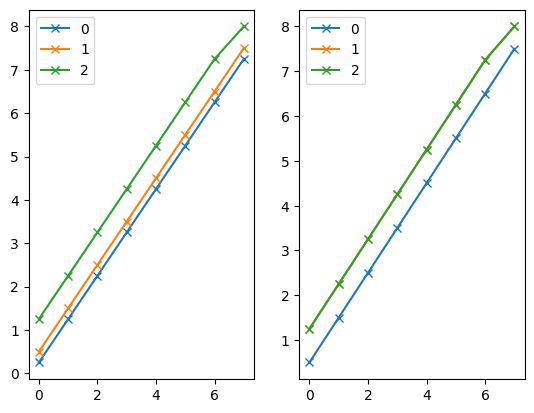

In [9]:
# ordered visual stimulation configuration (only works for one repetition)
# static_moving_t_s = np.array([0.5, 0.5, 0])
static_moving_t_s = np.array([0.25, 0.75, 0]) # test code
# static_moving_t_s = np.array([0.25, 0.5, 0.25]) # test code

nof_orient = 8

orient_angles_deg = np.arange(nof_orient) * (360/nof_orient)
orient_angles_rad = orient_angles_deg * (np.pi/180)
 
print(orient_angles_deg)

# conversion
nof_stim_steps = static_moving_t_s.size
tot_trail_t_s = np.sum(static_moving_t_s)

stim_tstamp_s = np.zeros((nof_orient, nof_stim_steps, 2))

cur_start_t_s = np.arange(nof_orient) * tot_trail_t_s
for i_step in range(nof_stim_steps):
    stim_tstamp_s[:, i_step, 0] = cur_start_t_s
    cur_start_t_s = cur_start_t_s + static_moving_t_s[i_step]
    stim_tstamp_s[:, i_step, 1] = cur_start_t_s

print(tot_trail_t_s)
print(stim_tstamp_s.shape)

stim_tstamp_s = 0.25 + stim_tstamp_s # test code
stim_tstamp_s[stim_tstamp_s > 8] = 8 # test_code

plt.figure()
for i in range(2):
    plt.subplot(1,2,i + 1)
    for i_step in range(nof_stim_steps):
        plt.plot(stim_tstamp_s[:,i_step,i], "-x", label = f"{i_step}")
    plt.legend()
    
stim_tstamp = (stim_tstamp_s * s_to_ms)/time_per_frame_ms
stim_tstamp = stim_tstamp.astype(int)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

In [13]:
# source configurations
# src_root_dir = r"M:\2023-05-11\M347\FOV02\Group01"
src_root_dir = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01"
# src_root_dir = r"J:\2023-10-10\M377_JEDI2P\FOV02\Group01"


# src_sub_dir_name = r"VolpyResults"
# src_sub_dir_name = r"VolpyResults_Ver01"
# src_sub_dir_name = r"VolpyResults_Ver01p1"
# src_sub_dir_name = r"VolpyResults_Ver01p2"
# src_sub_dir_name = r"VolpyResults_Ver01p6_NewMasNewkMC_STD5"
src_sub_dir_name = r"VolpyResults_Ver01p7_STD5"
src_hdf5_file_name = r"results.hdf5"

dst_root_dir = src_root_dir
# dst_dir_name = "StatsAnalysisSubtresholds"
# dst_dir_name = "StatsAnalysisSubtresholds_Ver01p7"
dst_dir_name = "StatsAnalysisSubtresholds_Ver02p3_FromVer01p7_Test"

# dst_dir_name = "StatsAnalysisOverSubTPlus3STD"

dst_plot_sub_dir_name = "Plots"

t_test_alpha = 0.05
anova_test_alpha = 0.05

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [14]:
# generate package name list 
src_pkg_names = listPkgNames(src_root_dir)
src_pkg_names = sortPkgNames(src_pkg_names)
print(src_pkg_names)

SAVE_PROGRESS(HISTORY_FILEPATH)

['Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F0_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F1_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F2_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F3_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F4_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F5_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F6_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F7_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F8_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F9_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F10_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F11_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F12_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F13_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F14_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F15_Pkg'
 'Olympus25X_M377_JEDI2P_FOV03_Group01_TS_CH0_CHA_F16_Pkg'
 'Olymp

In [15]:
# load spike event information
NFRAMES_KEY = "roi0\\volpy_estimates\\dFF"
roi_regex = r"roi\d+"

fields = [
    "roi{iroi:d}\\stdThreshold\\spikes_invalid",
    "roi{iroi:d}\\stdThreshold\\spikes_valid",
    "roi{iroi:d}\\volpy_estimates\\spikes",
]

dFF_key = "roi{iroi:d}\\volpy_estimates\\dFF"
snr_key =  "roi{iroi:d}\\volpy_estimates\\snr"
raw_dFF_key = "roi{iroi:d}\\volpy_estimates\\rawROI\\dFF"
F0_key = "roi{iroi:d}\\volpy_estimates\\F0"
t_key = "roi{iroi:d}\\volpy_estimates\\t"
raw_t_key = "roi{iroi:d}\\volpy_estimates\\rawROI\\t"

nof_fields = len(fields)
nof_roi = 0
nof_files = len(src_pkg_names)
nof_frames = 0

spike_events = None

#preprocess
for ipkg_name in [src_pkg_names[0]]:
    src_hdf5_file_path = os.path.join(src_root_dir, ipkg_name, src_sub_dir_name, src_hdf5_file_name)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        # print(hdf5_file.keys())
        # nof_frames = hdf5_file[NFRAMES_KEY].value.shape[0]
        # print(hdf5_file[NFRAMES_KEY].value.shape)
        nof_frames = hdf5_file[NFRAMES_KEY][()].shape[0]
        print(hdf5_file[NFRAMES_KEY][()].shape)
#         print(hdf5_file.keys()) # debug
        max_roi_num = 0
        for key in hdf5_file.keys():
            for istr in re.findall(roi_regex, key):
                cur_roi_num = int(istr[3:])
                max_roi_num = max(max_roi_num, cur_roi_num)
        nof_roi = max_roi_num + 1
        
spike_events = np.zeros((nof_roi, nof_fields, nof_files, nof_frames))
dFFs = np.zeros((nof_roi, nof_files, nof_frames))
raw_dFFs = np.zeros((nof_roi, nof_files, nof_frames))
F0 = np.zeros((nof_roi, nof_files, nof_frames))
snrs = np.zeros((nof_roi, nof_files))
t = np.zeros((nof_roi, nof_files, nof_frames))
raw_t = np.zeros((nof_roi, nof_files, nof_frames))


for ifile in range(nof_files):
    src_hdf5_file_path = os.path.join(src_root_dir, src_pkg_names[ifile], src_sub_dir_name, src_hdf5_file_name)
    # print(src_hdf5_file_path)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        for iroi in range(nof_roi):
            for ifield in range(nof_fields):
                # spike_idxs = hdf5_file[fields[ifield].format(iroi = iroi)].value
                spike_idxs = hdf5_file[fields[ifield].format(iroi = iroi)][()]

#                 print(spike_idxs)
                spike_events[iroi, ifield, ifile, spike_idxs] = 1
            # dFFs[iroi, ifile, :] = hdf5_file[dFF_key.format(iroi = iroi)].value
            dFFs[iroi, ifile, :] = hdf5_file[dFF_key.format(iroi = iroi)][()]
            raw_dFFs[iroi, ifile, :] = hdf5_file[raw_dFF_key.format(iroi = iroi)][()]
            F0[iroi, ifile, :] = hdf5_file[F0_key.format(iroi = iroi)][()]
            snrs[iroi, ifile] =  hdf5_file[snr_key.format(iroi = iroi)][()]
            t[iroi, ifile, :] = hdf5_file[t_key.format(iroi = iroi)][()]
            raw_t[iroi, ifile, :] = hdf5_file[raw_t_key.format(iroi = iroi)][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

(3100,)
Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


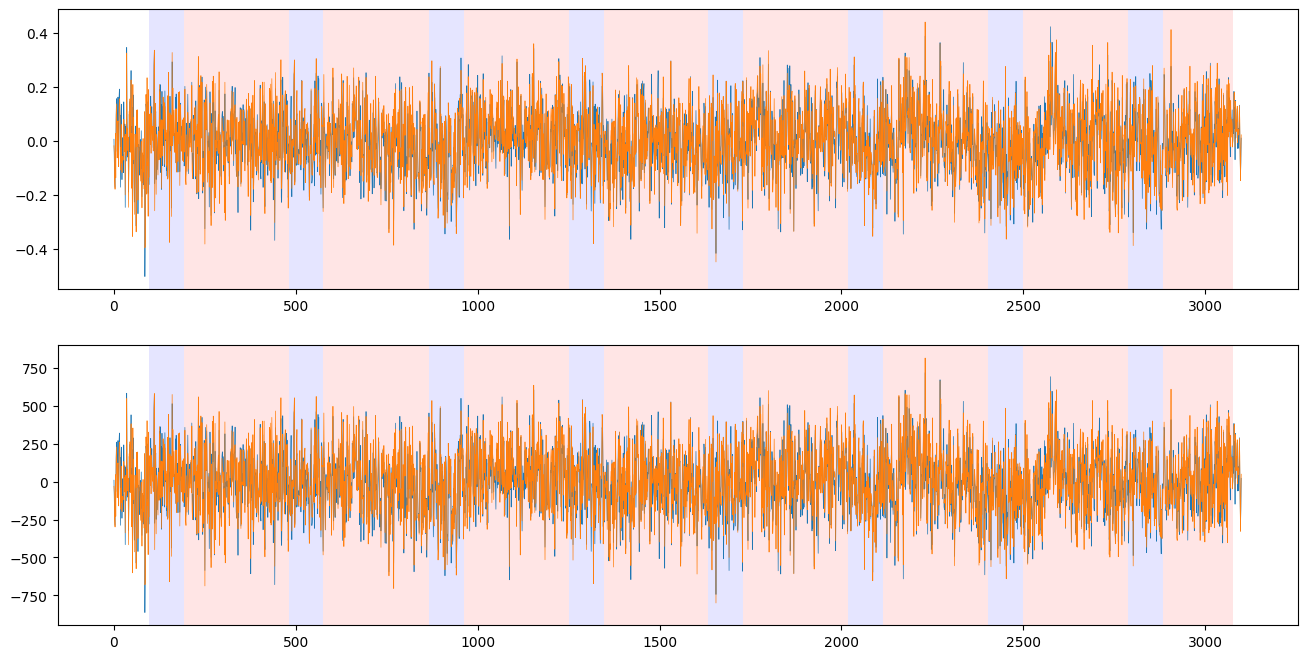

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [16]:
preview_i_roi = 9
preview_i_trial = 0

plt.figure(figsize = (16, 8) )
plt.subplot(2,1,1)
plt.plot(dFFs[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
plt.plot(raw_dFFs[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
stim_time_stamp_axvspan(stim_tstamp)
plt.subplot(2,1,2)
plt.plot(t[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
plt.plot(raw_t[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
# plt.plot(F0[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
stim_time_stamp_axvspan(stim_tstamp)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

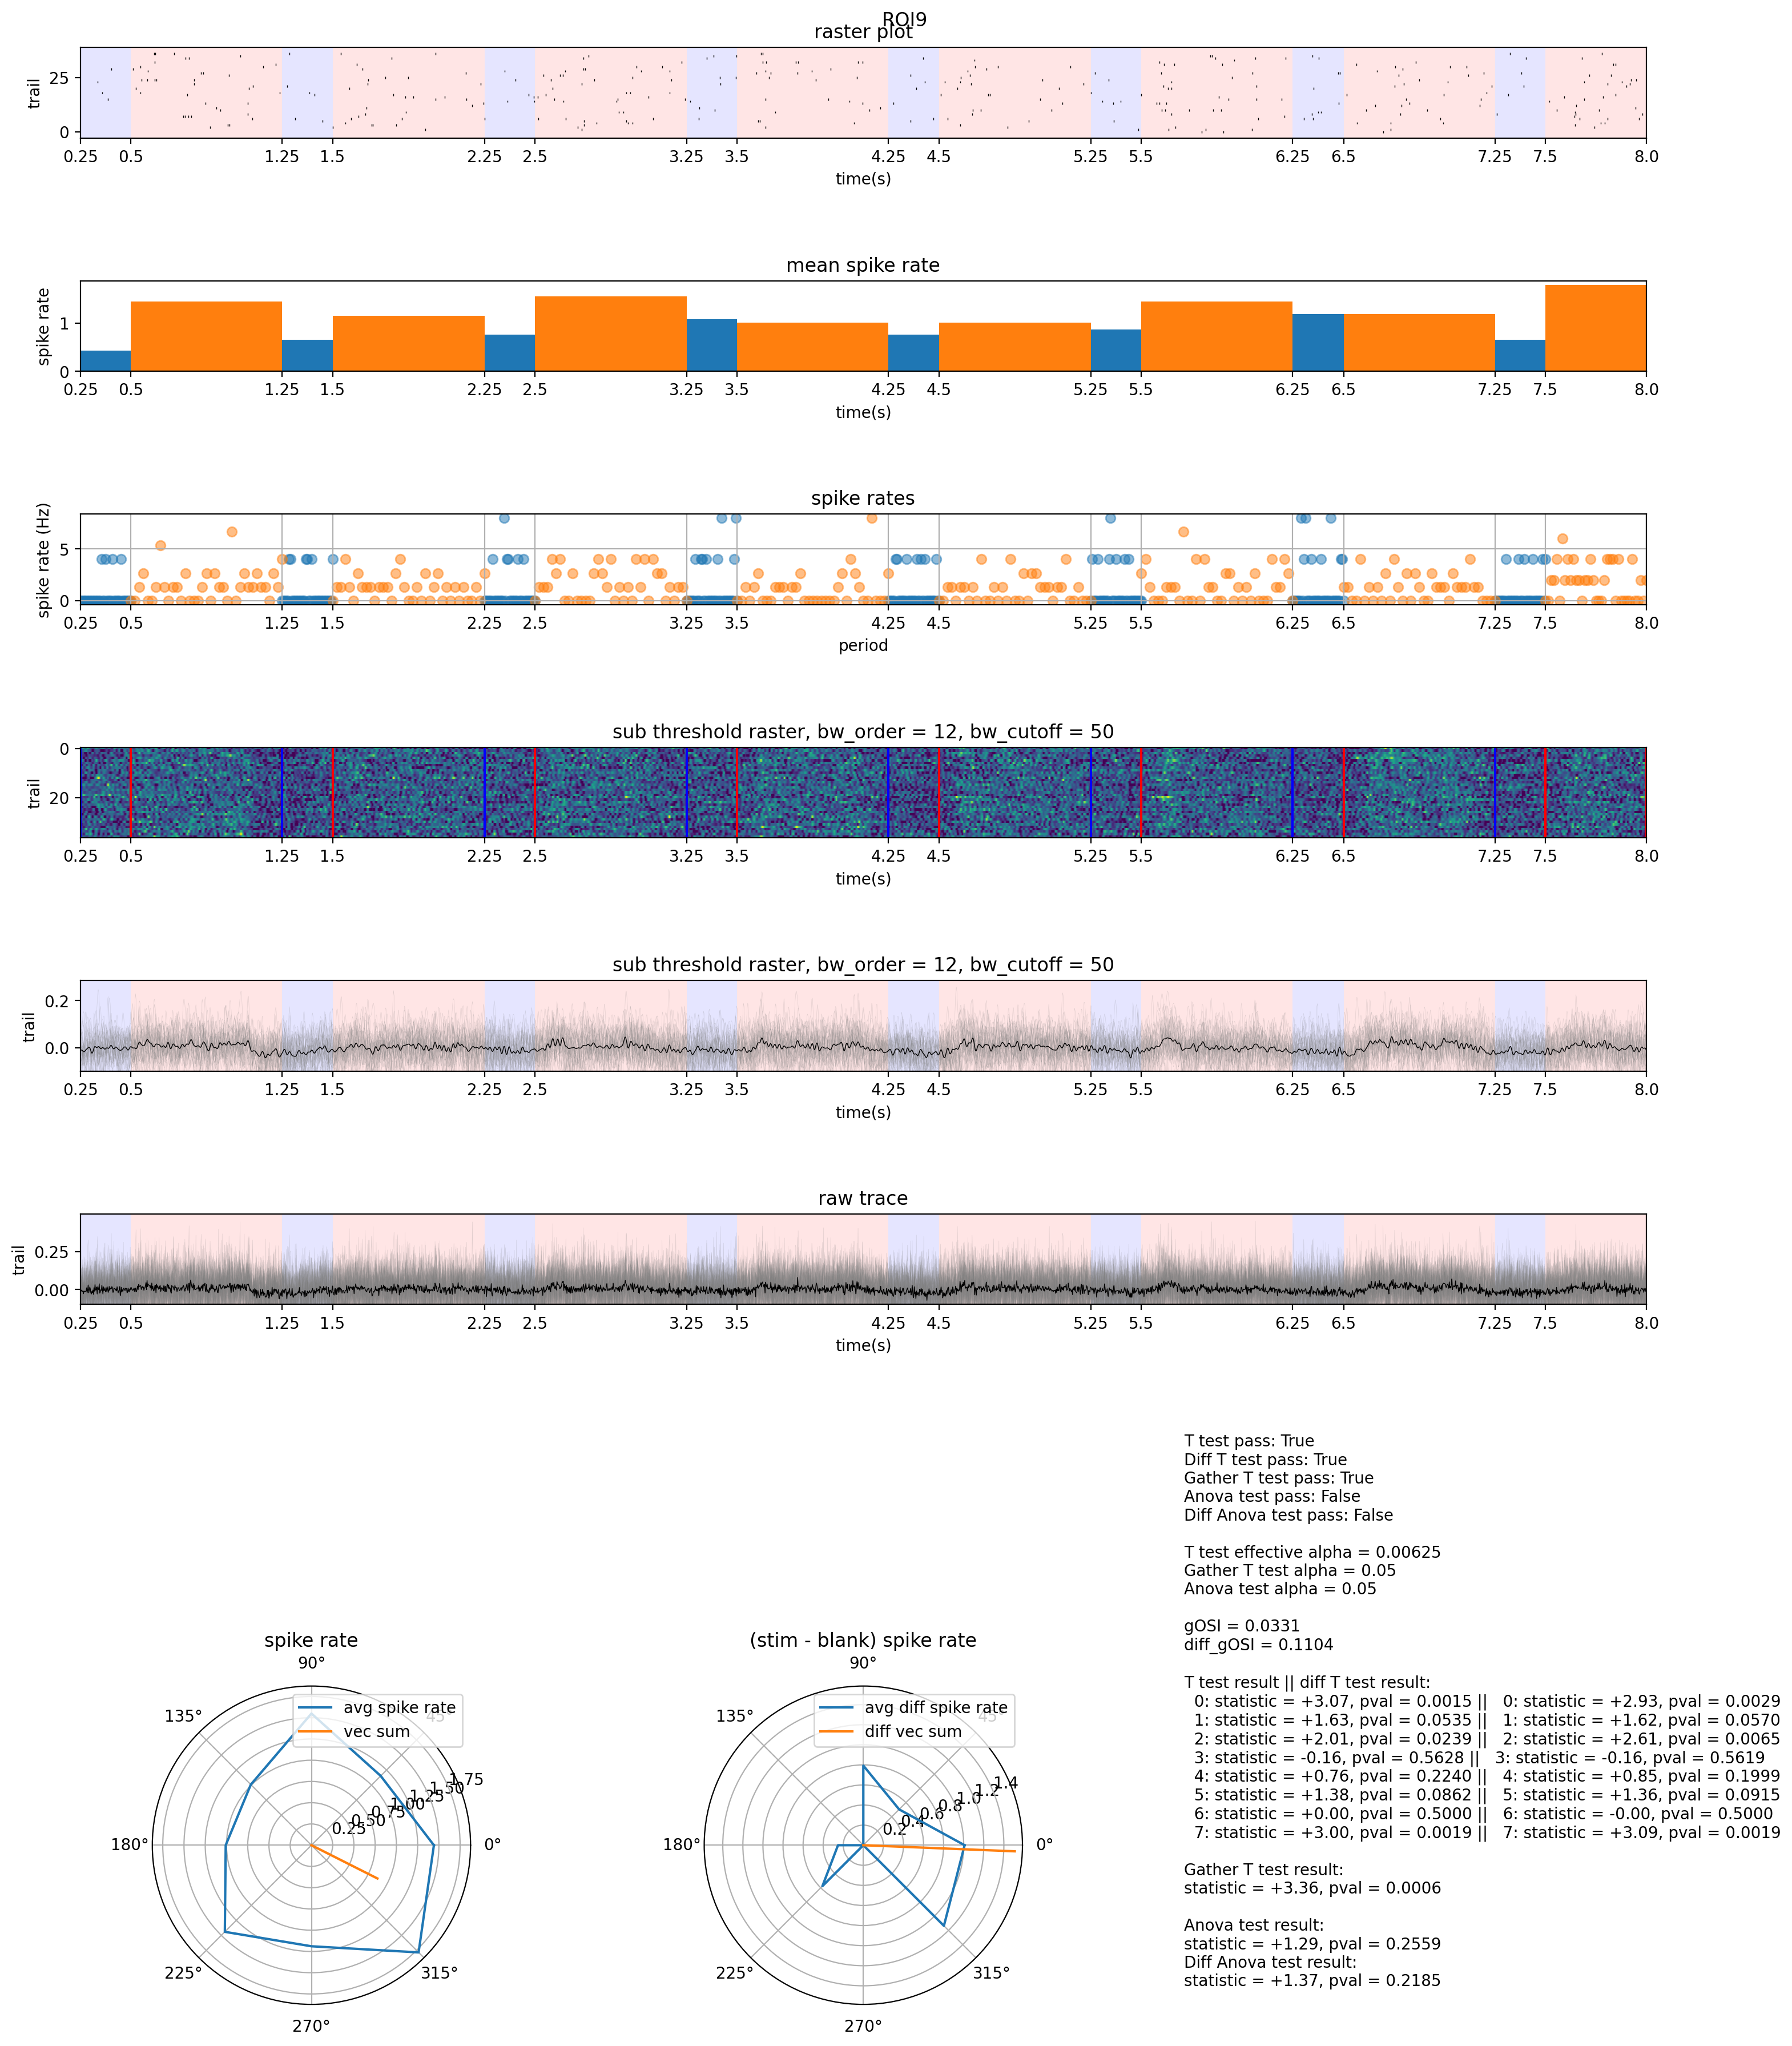

{'i_roi': 9, 'fs': 384.6153846153846, 'bw_order': 12, 'bw_cutoff': 50, 'stim_tstamp': array([[[  96,  192],
        [ 192,  480],
        [ 480,  480]],

       [[ 480,  576],
        [ 576,  865],
        [ 865,  865]],

       [[ 865,  961],
        [ 961, 1250],
        [1250, 1250]],

       [[1250, 1346],
        [1346, 1634],
        [1634, 1634]],

       [[1634, 1730],
        [1730, 2019],
        [2019, 2019]],

       [[2019, 2115],
        [2115, 2403],
        [2403, 2403]],

       [[2403, 2500],
        [2500, 2788],
        [2788, 2788]],

       [[2788, 2884],
        [2884, 3076],
        [3076, 3076]]]), 'stim_tstamp_s': array([[[0.25, 0.5 ],
        [0.5 , 1.25],
        [1.25, 1.25]],

       [[1.25, 1.5 ],
        [1.5 , 2.25],
        [2.25, 2.25]],

       [[2.25, 2.5 ],
        [2.5 , 3.25],
        [3.25, 3.25]],

       [[3.25, 3.5 ],
        [3.5 , 4.25],
        [4.25, 4.25]],

       [[4.25, 4.5 ],
        [4.5 , 5.25],
        [5.25, 5.25]],

       [[5.2

In [17]:
preview_i_roi = 9
preview_i_field = 1

spike_event = spike_events[preview_i_roi, preview_i_field, :, :]
dFF = dFFs[preview_i_roi, :]

result_summary = stats_analysis(
    preview_i_roi,
    spike_event,
    dFF,
    bw_order,
    bw_cutoff,
    fs,
    stim_tstamp,
    stim_tstamp_s,
    orient_angles_rad,
    t_test_alpha,
    anova_test_alpha,
    dst_dir_path = ".",
    process_mode = "show",
)

print(result_summary)

SAVE_PROGRESS(HISTORY_FILEPATH)

In [18]:
# batch processing
process_field = 1 

nof_roi = spike_events.shape[0]
nof_traces = spike_events.shape[2]
trace_len = spike_events.shape[3]
nof_orints = orient_angles_rad.shape[0]

dst_dir_path = os.path.join(dst_root_dir, dst_dir_name)
dst_plot_sub_dir_path = os.path.join(dst_dir_path, dst_plot_sub_dir_name)

if not os.path.isdir(dst_dir_path):
    os.makedirs(dst_dir_path)
    
if not os.path.isdir(dst_plot_sub_dir_path):
    os.makedirs(dst_plot_sub_dir_path)
    
result_summarys = []
for i_roi in range(nof_roi):
    
#     spike_event = spike_events[i_roi, process_field, :, :]
    
#     result_summary = stats_analysis(
#         i_roi,
#         spike_event,
#         stim_tstamp,
#         stim_tstamp_s,
#         orient_angles_rad,
#         t_test_alpha,
#         anova_test_alpha,
#         dst_dir_path = dst_plot_sub_dir_path,
#         process_mode = "save",
#     )
    
    spike_event = spike_events[i_roi, process_field, :, :]
    dFF = dFFs[i_roi, :]

    result_summary = stats_analysis(
        i_roi,
        spike_event,
        dFF,
        bw_order,
        bw_cutoff,
        fs,
        stim_tstamp,
        stim_tstamp_s,
        orient_angles_rad,
        t_test_alpha,
        anova_test_alpha,
        dst_dir_path = dst_plot_sub_dir_path,
        # process_mode = "save",
        process_mode = "none",
    )
    
    result_summarys.append(result_summary)

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [19]:
# save results to hdf5 file
dst_hdf5_file_name = "stats_analysis_data.hdf5"
dst_hdf5_file_path = os.path.join(dst_dir_path, dst_hdf5_file_name)

with h5py.File(dst_hdf5_file_path, "w") as hdf5_file:
    hdf5_file.create_dataset("time_per_frame_ms", data = time_per_frame_ms)
    hdf5_file.create_dataset("ms_to_s", data = ms_to_s)
    hdf5_file.create_dataset("s_to_ms", data = s_to_ms)
    hdf5_file.create_dataset("bw_order", data = bw_order)
    hdf5_file.create_dataset("bw_cutoff", data = bw_cutoff)
    hdf5_file.create_dataset("fs", data = fs)
    hdf5_file.create_dataset("static_moving_t_s", data = static_moving_t_s)
    hdf5_file.create_dataset("nof_orient", data = nof_orient)
    hdf5_file.create_dataset("orient_angles_deg", data = orient_angles_deg)
    hdf5_file.create_dataset("orient_angles_rad", data = orient_angles_rad)
    hdf5_file.create_dataset("stim_tstamp_s", data = stim_tstamp_s)
    hdf5_file.create_dataset("stim_tstamp", data = stim_tstamp)
    hdf5_file.create_dataset("src_root_dir", data = src_root_dir)
    hdf5_file.create_dataset("src_sub_dir_name", data = src_sub_dir_name)
    hdf5_file.create_dataset("src_hdf5_file_name", data = src_hdf5_file_name)
    for i_str in range(len(src_pkg_names)):
        hdf5_file.create_dataset(f"src_pkg_names[{i_str}]", data = src_pkg_names.tolist()[i_str])
    hdf5_file.create_dataset("NFRAMES_KEY", data = NFRAMES_KEY)
    for i_str in range(len(fields)):
        hdf5_file.create_dataset(f"fields[{i_str}]", data = fields[i_str])
    hdf5_file.create_dataset("nof_fields", data = nof_fields)
    hdf5_file.create_dataset("nof_roi", data = nof_roi)
    hdf5_file.create_dataset("nof_files", data = nof_files)
    hdf5_file.create_dataset("nof_frames", data = nof_frames)
    hdf5_file.create_dataset("spike_events", data = spike_events)
    hdf5_file.create_dataset("dFFs", data = dFFs)
    hdf5_file.create_dataset("snrs", data = snrs)
    hdf5_file.create_dataset("raw_dFFs", data = raw_dFFs)
    hdf5_file.create_dataset("F0", data = F0)
    hdf5_file.create_dataset("t", data = t)
    hdf5_file.create_dataset("raw_t", data = raw_t)
    hdf5_file.create_dataset("process_field", data = process_field)
    
    stats_result_tage = "stats_result"
    for i_roi in range(nof_roi):
        cur_result = result_summarys[i_roi]
        roi_num = cur_result["i_roi"]
        roi_name = f"roi{roi_num}"
        dirct_save_keys = [
            "cur_spike_event",
            "cur_spike_cnts",
            "cur_spike_rate",
            "t_test_pvals",
            "t_test_effective_alpha",
            "t_test_alpha",
            "anova_test_alpha",
            "t_test_pass",
            "diff_t_test_pass",
            "gather_t_test_pass",
            "anova_test_pass",
            "diff_anova_test_pass",
            "responses",
            "diff_responses",
            "gOSI",
            "diff_gOSI",
            "fs",
            "bw_order",
            "bw_cutoff",
            "cur_dFF",
            "cur_subthreshold_dFF",
            "diff_t_test_pvals",
        ]
        for key in dirct_save_keys:
            hdf5_save_key = os.path.join(roi_name, key)
            hdf5_file.create_dataset(hdf5_save_key, data = cur_result[key])
        
        vec_sum_hdf5_save_key = os.path.join(roi_name, "vec_sum_complex")
        hdf5_file.create_dataset(vec_sum_hdf5_save_key, data = cur_result["vec_sum_complex"])
        hdf5_file.create_dataset(vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["vec_sum_complex"]))
        hdf5_file.create_dataset(vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["vec_sum_complex"]))

        gather_t_test_result_hdf5_save_key = os.path.join(roi_name, "gather_t_test_result")
        hdf5_file.create_dataset(gather_t_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["gather_t_test_result"].statistic)
        hdf5_file.create_dataset(gather_t_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["gather_t_test_result"].pvalue)
        
        anova_test_result_hdf5_save_key = os.path.join(roi_name, "anova_test_result")
        hdf5_file.create_dataset(anova_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["anova_test_result"].statistic)
        hdf5_file.create_dataset(anova_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["anova_test_result"].pvalue)

        diff_anova_test_result_hdf5_save_key = os.path.join(roi_name, "diff_anova_test_result")
        hdf5_file.create_dataset(diff_anova_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["diff_anova_test_result"].statistic)
        hdf5_file.create_dataset(diff_anova_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["diff_anova_test_result"].pvalue)
        
        t_test_results_hdf5_save_key = os.path.join(roi_name, "t_test_results")
        for i_test_res in range(len(cur_result["t_test_results"])):
            hdf5_file.create_dataset(t_test_results_hdf5_save_key + f"[{i_test_res}].statistic",
                                    data = cur_result["t_test_results"][i_test_res].statistic)
            hdf5_file.create_dataset(t_test_results_hdf5_save_key + f"[{i_test_res}].pvalue",
                                    data = cur_result["t_test_results"][i_test_res].pvalue)
            
        diff_t_test_results_hdf5_save_key = os.path.join(roi_name, "diff_t_test_results")
        for i_test_res in range(len(cur_result["diff_t_test_results"])):
            hdf5_file.create_dataset(diff_t_test_results_hdf5_save_key + f"[{i_test_res}].statistic",
                                    data = cur_result["diff_t_test_results"][i_test_res].statistic)
            hdf5_file.create_dataset(diff_t_test_results_hdf5_save_key + f"[{i_test_res}].pvalue",
                                    data = cur_result["diff_t_test_results"][i_test_res].pvalue)
            
SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: C:\Users\zhong\Documents\IPythonHistory\JEDI2PStatsAnalysisBathSubthresholdVer02_2023-10-25.py


In [ ]:
for ifile in range(1):
    src_hdf5_file_path = os.path.join(src_root_dir, src_pkg_names[ifile], src_sub_dir_name, src_hdf5_file_name)
    print(src_hdf5_file_path)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        print(hdf5_file.keys())

In [ ]:
with h5py.File(dst_hdf5_file_path, "r") as hdf5_file:
    print(hdf5_file.keys())